In [1]:
!pip install git+git://github.com/linalgo/linalgo-sdk.git requests pillow

  Cloning git://github.com/linalgo/linalgo-sdk.git to /tmp/pip-req-build-yjmr9brp
  Running command git clone -q git://github.com/linalgo/linalgo-sdk.git /tmp/pip-req-build-yjmr9brp


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import requests, io
from PIL import Image

from linalgo.annotate.models import Document, Annotation, Entity
from linalgo.hub.client import LinalgoClient
from linalgo.annotate.bbox import draw_bounding_boxes

In [4]:
client = LinalgoClient(token=MY_TOKEN, api_url='https://prod.linhub.api.linalgo.com/v1')
task = client.get_task('a9b4a03b-3af5-476f-8656-c69a32ea9866', verbose=True)

Retrivieving task with id a9b4a03b-3af5-476f-8656-c69a32ea9866...
Retrieving annotators... (9 found)
Retrieving entities... (8 found)
Retrieving documents... (348 found)
Retrieving annotations... (35049 found)


In [5]:
doc = task.documents[0]
response = requests.get(doc.content)
img = Image.open(io.BytesIO(response.content))

In [6]:
doc.annotations 
doc.content

'https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-160.png'

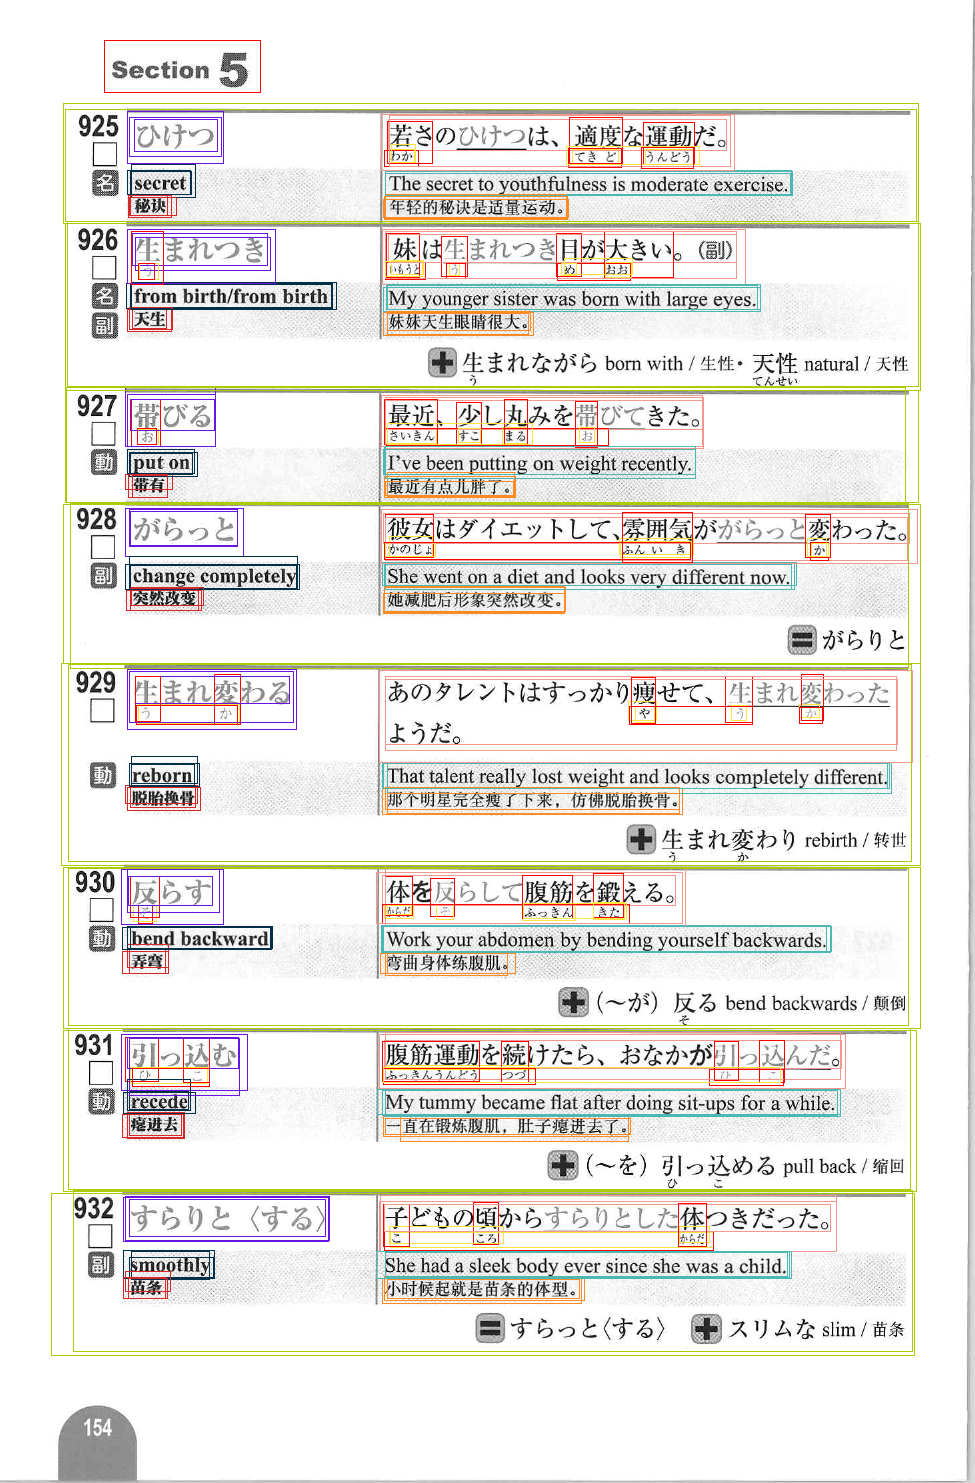

In [7]:
draw_bounding_boxes(img, doc.annotations)

In [8]:
doc.content

'https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-160.png'

In [9]:
len(task.documents)

348

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
ent_list =[]
coord_list = []
for i in range(len(task.documents)): 
    document = task.documents[i]
    for ant in range(len(document.annotations)): 
        annotation = document.annotations[ant]
        entity = annotation.entity.name
        coordinates = annotation.target.selectors[0]
        ent_list.append(entity)
        coord_list.append(coordinates)

In [12]:
top= []
bottom=[]
left=[]
right=[]
area = []
width=[]

for i in range(len(coord_list)):
    top.append(coord_list[i].top)
    bottom.append(coord_list[i].bottom)
    left.append(coord_list[i].left)
    right.append(coord_list[i].right)
    area.append(coord_list[i].area)
    width.append(coord_list[i].width)

In [13]:
df= pd.DataFrame(ent_list)
df.columns = ['Entity']
df['top'] = pd.DataFrame(top)
df['bottom'] = pd.DataFrame(bottom)
df['left'] = pd.DataFrame(left)
df['right'] = pd.DataFrame(right)
df['area'] = pd.DataFrame(area)
df['width'] = pd.DataFrame(width)

In [14]:
# len(df)
# df = df.drop_duplicates() # Remove duplicates
# len(df)

In [15]:
df = df.dropna()
df.isnull().sum().sort_values(ascending=False)

Entity    0
top       0
bottom    0
left      0
right     0
area      0
width     0
dtype: int64

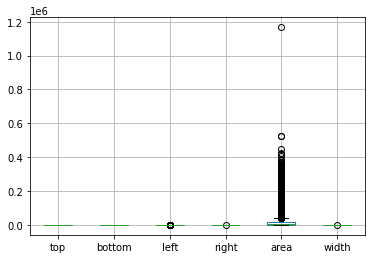

In [16]:
df.boxplot();

In [17]:
df.describe()

,top,bottom,left,right,area,width
count,34934.000000,34934.000000,34934.000000,34934.000000,3.493400e+04,34934.000000
mean,683.105432,726.999219,248.665269,555.903290,2.191838e+04,307.238021
std,347.159538,347.100309,148.021945,294.114510,4.291950e+04,250.944435
min,41.281812,106.153231,7.718756,94.369855,5.423352e-01,0.736434
25%,387.159647,432.418082,128.752627,234.355035,2.435410e+03,92.534067
50%,669.187842,713.098683,140.687739,624.604706,5.767560e+03,226.658824
75%,975.464482,1020.652941,385.339191,856.914044,1.674342e+04,468.676964
max,1416.806154,1473.923706,888.636626,2280.279739,1.167503e+06,1565.702326


In [18]:
df[df.area ==df.area.max()]

,Entity,top,bottom,left,right,area,width
1872,item,214.567076,960.240775,714.577413,2280.279739,1.167503e+06,1565.702326


In [19]:
indexNames = df[df.area ==df.area.max()].index
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(df[['top', 'bottom', 'left', 'right', 'area', 'width']]) 

df['top'],  df['bottom'], df['left'], df['right'], df['area'], df['width']= scaler.transform(df[['top', 'bottom', 'left', 'right', 'area', 'width']]).T
df.head()

,Entity,top,bottom,left,right,area,width
0,furi,0.483414,0.450319,0.713104,0.631530,0.000560,0.019065
1,word-jp,0.339510,0.328982,0.133790,0.167807,0.010752,0.125424
2,word-en,0.177018,0.147087,0.139765,0.267367,0.008650,0.214529
3,item,0.335988,0.411035,0.070817,0.918577,0.264396,0.899486
4,sent-en,0.643127,0.618797,0.424659,0.829692,0.022797,0.480362


In [21]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.3)
X_train = train_data.drop(['Entity'], axis = 1)
y_train = train_data.Entity
X_test = test_data.drop(['Entity'], axis = 1)
y_test = test_data.Entity
X_train

,top,bottom,left,right,area,width
16049,0.847025,0.839418,0.417918,0.907440,0.047897,0.560730
22228,0.772881,0.768102,0.440824,0.753352,0.036651,0.392425
8486,0.284003,0.254281,0.150712,0.166677,0.004278,0.108349
9881,0.185562,0.155570,0.148044,0.146953,0.003706,0.092100
3311,0.399684,0.369818,0.432604,0.609247,0.009829,0.263048
...,...,...,...,...,...,...
1527,0.203786,0.170154,0.436123,0.850250,0.015083,0.489089
2911,0.181667,0.151840,0.139679,0.157041,0.004455,0.109610
20357,0.521367,0.493466,0.430624,0.562060,0.008911,0.220010
28621,0.900481,0.867852,0.142960,0.267764,0.005021,0.211885


In [22]:
df.Entity.unique()

array(['furi', 'word-jp', 'word-en', 'item', 'sent-en', 'word-zh',
       'sent-zh', 'sent-jp'], dtype=object)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=8)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.7456106870229008

In [24]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
cv_results = cross_validate(neigh, X_train, y_train, cv=5, scoring="accuracy")
cv_results['test_score'].mean()

0.7398272441473613

In [25]:
from sklearn.model_selection import learning_curve

train_sizes = [250,500,750,1000,1150, 1500, 1750, 2000]
train_sizes, train_scores, test_scores = learning_curve(
    estimator=KNeighborsClassifier(), X=X_train, y=y_train, train_sizes=train_sizes, cv=5, scoring="accuracy")

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

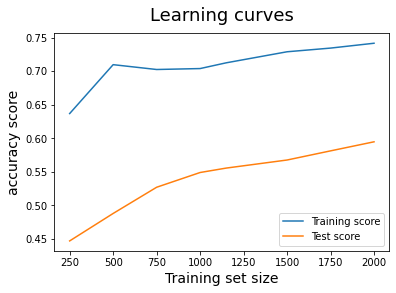

In [26]:
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('accuracy score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend();